In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import defaultdict
import ast


In [2]:
restaurant_frequency = defaultdict(int)

with open('business.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        categories = json_line.get('categories')
        if categories and 'Chinese' in categories and 'Restaurants' in categories:
            city = json_line.get('city', 'Unknown')
            restaurant_frequency[city] += 1

            
sorted_restaurant_frequency = sorted(restaurant_frequency.items(), key=lambda item: item[1], reverse=True)
# sorted_restaurant_frequency

In [3]:
restaurants_data = []

with open('business.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        if 'categories' in json_line and 'state' in json_line:
            state = json_line['state']
            city = json_line['city']
            categories = json_line['categories']
            if categories and 'Chinese' in categories and 'Restaurants' in categories and state == 'PA' and city == 'Philadelphia':
                restaurants_data.append(json_line)
                
restaurants_df = pd.DataFrame(restaurants_data)
# restaurants_df.to_csv('chinese_restaurants_philadelphia.csv', index=False)
# print(restaurants_df.drop_duplicates(subset='business_id'))
restaurants_df.rename(columns={'stars': 'avg_star'}, inplace=True)
# restaurants_df.info()

In [4]:
all_keys = set()
for restaurant in restaurants_data:
    if 'attributes' in restaurant and restaurant['attributes']:
        all_keys.update(restaurant['attributes'].keys())

split_attributes_list = []
for restaurant in restaurants_data:
    new_restaurant_data = {k: v for k, v in restaurant.items() if k != 'attributes'}
    attributes_data = {}
    if 'attributes' in restaurant and restaurant['attributes']:
        for key in all_keys:
            if key in restaurant['attributes']:
                try:
                    value = restaurant['attributes'][key].replace("'", '"')
                    attributes_data[key] = json.loads(value)
                except json.JSONDecodeError:
                    attributes_data[key] = restaurant['attributes'][key]
            else:
                attributes_data[key] = None
    new_restaurant_data.update(attributes_data)
    split_attributes_list.append(new_restaurant_data)
    
split_attributes_list = pd.DataFrame(split_attributes_list)
split_attributes_list.rename(columns={'stars': 'avg_star'}, inplace=True)
# split_attributes_list.to_csv('split_attributes_list.csv', index=False)
columns_to_keep = ['business_id', 'name', 'postal_code', 'avg_star', 'review_count', 
                   'categories', 'RestaurantsGoodForGroups', 'OutdoorSeating',
                   'BusinessAcceptsCreditCards', 'RestaurantsTakeOut', 'RestaurantsReservations',
                   'RestaurantsDelivery', 'RestaurantsPriceRange2', 'Ambience', 'BusinessParking']
business_df = split_attributes_list[columns_to_keep]

In [5]:
def remove_u_prefix_from_dict(info):
    if info in [None, 'None', 'nan']:
        return info
    try:
        dictionary = ast.literal_eval(info)
    except (ValueError, SyntaxError):
        return info
    processed_dict = {k.lstrip("u"): v for k, v in dictionary.items()}
    return processed_dict

business_df.loc[:, 'BusinessParking'] = business_df['BusinessParking'].apply(remove_u_prefix_from_dict)
business_df.loc[:, 'Ambience'] = business_df['Ambience'].apply(remove_u_prefix_from_dict)
business_df.loc[:, business_df.columns[6:13]] =  business_df.loc[:, business_df.columns[6:13]].replace(['', None, 'None'], np.nan)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 471 non-null    object 
 1   name                        471 non-null    object 
 2   postal_code                 471 non-null    object 
 3   avg_star                    471 non-null    float64
 4   review_count                471 non-null    int64  
 5   categories                  471 non-null    object 
 6   RestaurantsGoodForGroups    401 non-null    object 
 7   OutdoorSeating              390 non-null    object 
 8   BusinessAcceptsCreditCards  432 non-null    object 
 9   RestaurantsTakeOut          442 non-null    object 
 10  RestaurantsReservations     403 non-null    object 
 11  RestaurantsDelivery         424 non-null    object 
 12  RestaurantsPriceRange2      410 non-null    float64
 13  Ambience                    388 non

In [6]:
all_categories = ', '.join(business_df['categories'])
words = all_categories.split(', ')
word_series = pd.Series(words)
word_freq = word_series.value_counts()
word_freq.head(20)

Restaurants               471
Chinese                   471
Food                       77
Asian Fusion               72
Dim Sum                    48
Japanese                   46
Seafood                    43
Sushi Bars                 31
Szechuan                   31
Noodles                    30
Cantonese                  27
Thai                       26
Nightlife                  24
Bars                       21
Vietnamese                 19
Soup                       19
Specialty Food             17
American (Traditional)     17
Fast Food                  16
Hot Pot                    15
Name: count, dtype: int64

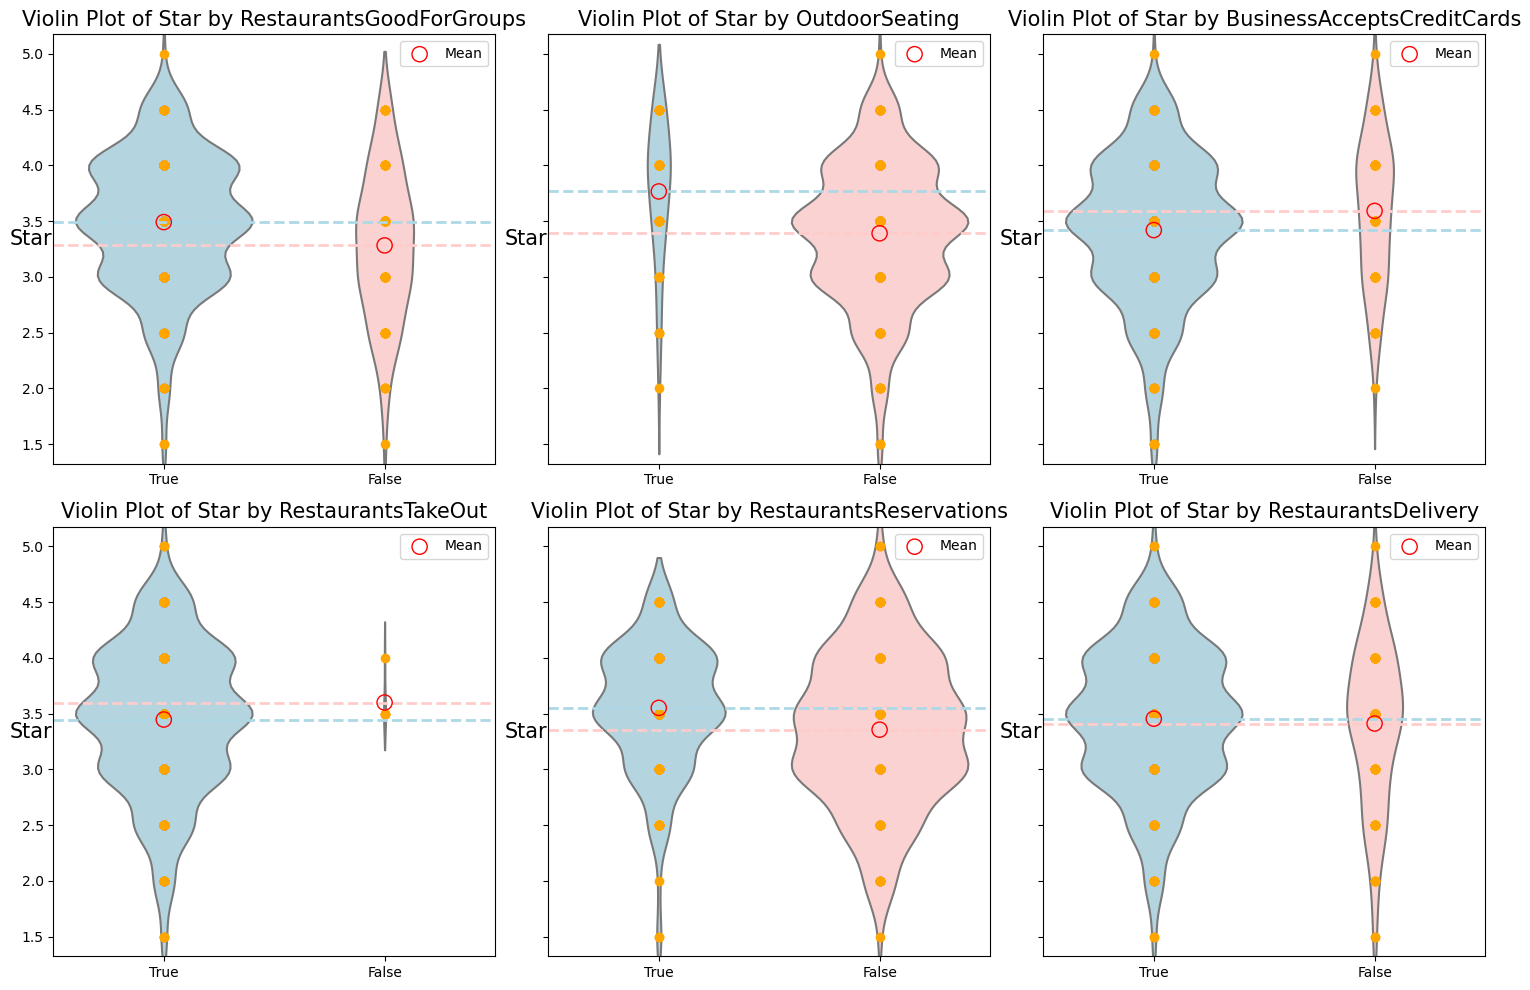

In [7]:
columns_of_interest = ['RestaurantsGoodForGroups', 'OutdoorSeating', 'BusinessAcceptsCreditCards',
                       'RestaurantsTakeOut', 'RestaurantsReservations', 'RestaurantsDelivery']

for col in columns_of_interest[:]:
    business_df.loc[:, col] = business_df[col].replace({'True': True, 'False': False})

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
category_order = [True, False]

for i, col in enumerate(columns_of_interest[:]):
    ax = axes[i // 3, i % 3]
    sns.violinplot(x=col, y='avg_star', data=business_df, order=category_order, scale='count',
                   palette={True: "#add8e6", False: "#ffcccb"}, inner=None, ax=ax)
    means = business_df.groupby(col)['avg_star'].mean()
    ax.scatter(x=[0, 1], y=[means[True], means[False]], color='red', s=120, 
               facecolors='none', zorder=3, label='Mean')
    sns.stripplot(x=col, y='avg_star', data=business_df, order=category_order, color='orange',
                  jitter=False, size=7, ax=ax, zorder=2)
    ax.axhline(y=means[True], color='#add8e6', linestyle='--', linewidth=2)
    ax.axhline(y=means[False], color='#ffcccb', linestyle='--', linewidth=2)
    ax.set_title(f'Violin Plot of Star by {col}', fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('Star', rotation=0, fontsize=15)
    ax.yaxis.set_label_coords(-0.05,0.5)
    ax.legend()
plt.tight_layout()
plt.show()

In [8]:
def get_percentage_distribution(df, star_ratings):
    counts = df['avg_star'].value_counts()
    percentages = (counts / counts.sum() * 100).reindex(star_ratings).fillna(0).round(1)
    return percentages.tolist()

star_ratings = sorted(business_df['avg_star'].unique())

summary_table = []

for feature in columns_of_interest:
    for value in [True, False]:
        feature_data = business_df[business_df[feature] == value]
        count = feature_data.shape[0]
        mean = (feature_data['avg_star'].mean()).round(1)
        percentage_distributions = get_percentage_distribution(feature_data, star_ratings)
        summary_table.append([feature, value, count, mean] + percentage_distributions)

column_names = ['Attributes', 'Type', 'Count', 'Mean'] + [f'% of {star} Stars' for star in star_ratings]
summary_df = pd.DataFrame(summary_table, columns=column_names)
summary_df

,Attributes,Type,Count,Mean,% of 1.5 Stars,% of 2.0 Stars,% of 2.5 Stars,% of 3.0 Stars,% of 3.5 Stars,% of 4.0 Stars,% of 4.5 Stars,% of 5.0 Stars
0,RestaurantsGoodForGroups,True,302,3.5,0.7,2.0,7.0,23.5,31.5,26.8,8.3,0.3
1,RestaurantsGoodForGroups,False,99,3.3,1.0,4.0,16.2,26.3,28.3,17.2,7.1,0.0
2,OutdoorSeating,True,45,3.8,0.0,2.2,6.7,8.9,22.2,37.8,22.2,0.0
3,OutdoorSeating,False,345,3.4,0.9,2.9,10.1,25.2,32.5,21.2,7.0,0.3
4,BusinessAcceptsCreditCards,True,356,3.4,1.1,3.1,9.8,22.5,32.3,22.8,8.1,0.3
5,BusinessAcceptsCreditCards,False,76,3.6,0.0,1.3,9.2,21.1,22.4,31.6,13.2,1.3
6,RestaurantsTakeOut,True,437,3.4,0.9,3.4,9.8,22.0,29.7,23.8,9.6,0.7
7,RestaurantsTakeOut,False,5,3.6,0.0,0.0,0.0,0.0,80.0,20.0,0.0,0.0
8,RestaurantsReservations,True,173,3.6,1.2,0.6,5.8,17.9,35.8,31.2,7.5,0.0
9,RestaurantsReservations,False,230,3.4,0.4,4.8,12.2,27.4,26.1,20.0,8.3,0.9


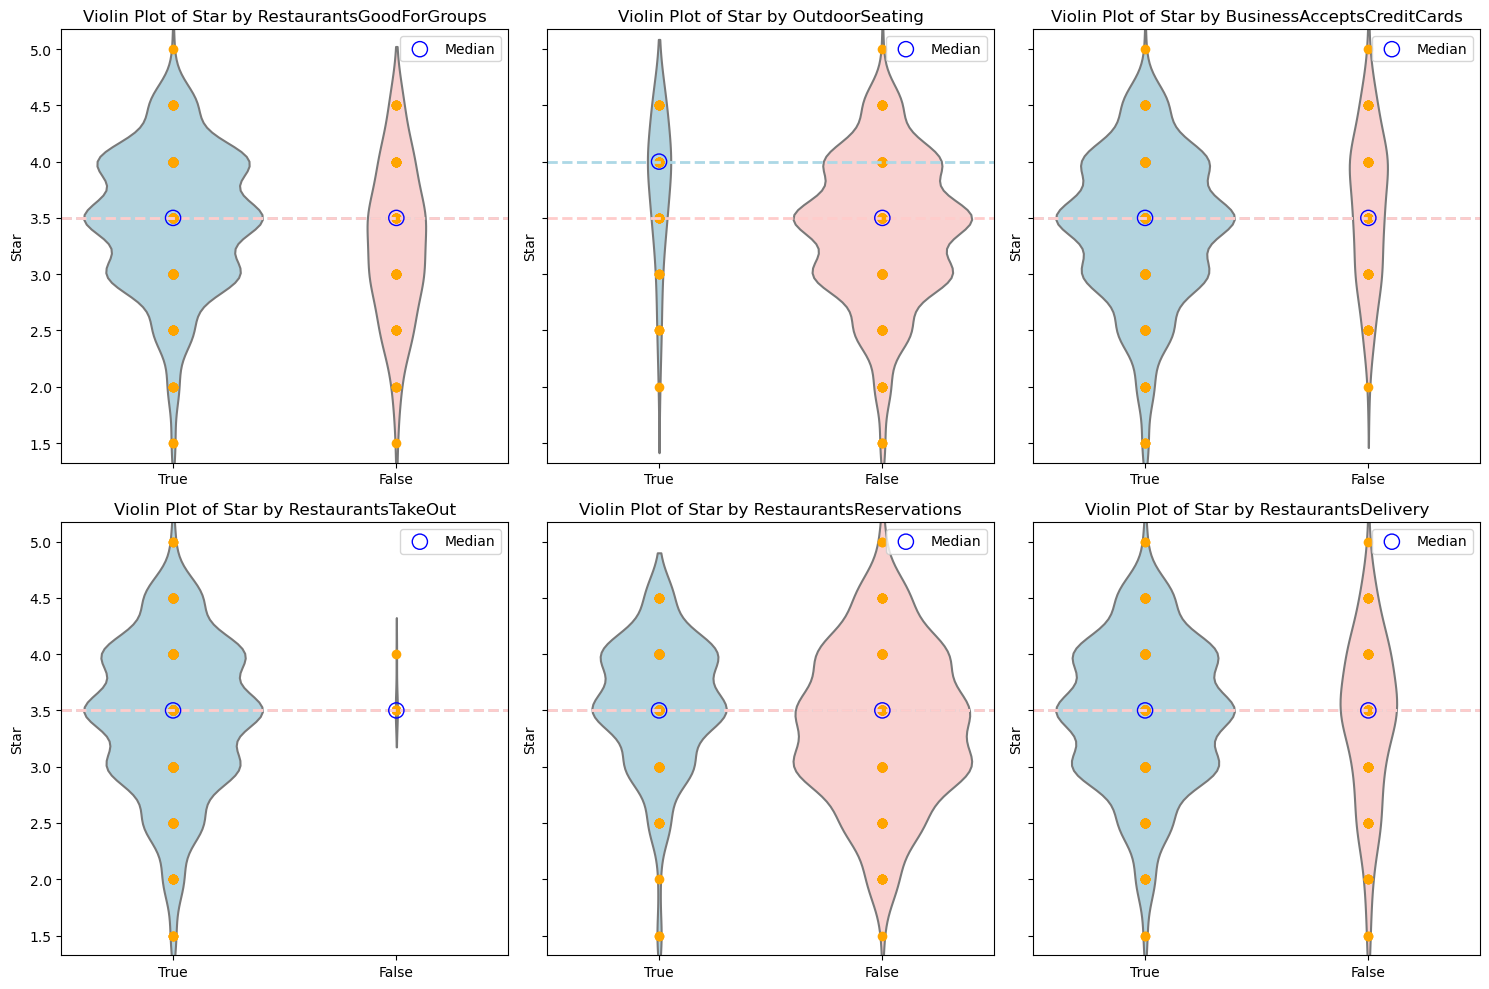

In [9]:
for col in columns_of_interest[:]:
    business_df.loc[:, col] = business_df[col].replace({'True': True, 'False': False})

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
category_order = [True, False]

for i, col in enumerate(columns_of_interest[:]):
    ax = axes[i // 3, i % 3]
    sns.violinplot(x=col, y='avg_star', data=business_df, order=category_order, scale='count',
                   palette={True: "#add8e6", False: "#ffcccb"}, inner=None, ax=ax)
    medians = business_df.groupby(col)['avg_star'].median()
    ax.scatter(x=[0, 1], y=[medians[True], medians[False]], color='blue', s=120,
               facecolors='none', zorder=3, label='Median')
    sns.stripplot(x=col, y='avg_star', data=business_df, order=category_order, color='orange',
                  jitter=False, size=7, ax=ax, zorder=2)
    ax.axhline(y=medians[True], color='#add8e6', linestyle='--', linewidth=2)
    ax.axhline(y=medians[False], color='#ffcccb', linestyle='--', linewidth=2)
    ax.set_title(f'Violin Plot of Star by {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Star')
    ax.legend()
plt.tight_layout()
plt.show()

In [10]:
price_range_counts = business_df['RestaurantsPriceRange2'].value_counts()
average_stars_by_price_range = business_df.groupby('RestaurantsPriceRange2')['avg_star'].mean().round(1)
median_stars_by_price_range = business_df.groupby('RestaurantsPriceRange2')['avg_star'].median().round(1)
proportion_df = business_df.groupby(['RestaurantsPriceRange2', 'avg_star']).size().reset_index(name='count')
total_counts = proportion_df.groupby('RestaurantsPriceRange2')['count'].transform('sum')
proportion_df['proportion'] = (((proportion_df['count'] / total_counts)) *100).round(1)
proportion_pivot = proportion_df.pivot(index='RestaurantsPriceRange2',
                                       columns='avg_star', values='proportion').fillna(0)
PriceRange = (pd.DataFrame({'Number': price_range_counts, 'Mean': average_stars_by_price_range,
    'Median': median_stars_by_price_range}).join(proportion_pivot, on='RestaurantsPriceRange2')
              .reset_index().rename(columns={'RestaurantsPriceRange2': 'Price Range'}))
PriceRange = PriceRange.rename(columns={col: f'{col} star %' for col in proportion_pivot.columns})
PriceRange

,Price Range,Number,Mean,Median,1.5 star %,2.0 star %,2.5 star %,3.0 star %,3.5 star %,4.0 star %,4.5 star %,5.0 star %
0,1.0,188,3.4,3.5,1.6,3.7,11.2,24.5,28.7,21.3,9.0,0.0
1,2.0,211,3.5,3.5,0.5,1.9,9.5,22.7,31.8,26.5,6.2,0.9
2,3.0,9,3.8,3.5,0.0,0.0,0.0,11.1,44.4,22.2,22.2,0.0
3,4.0,2,3.0,3.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


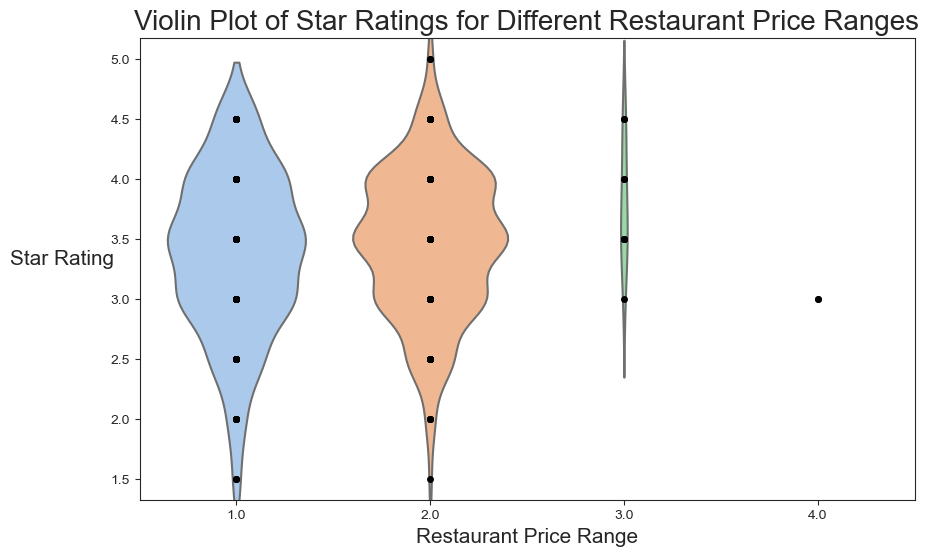

In [11]:
sns.set_style('ticks')
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=business_df, x='RestaurantsPriceRange2', y='avg_star', scale='count', inner=None, palette=sns.color_palette("pastel"))
sns.stripplot(data=business_df, x='RestaurantsPriceRange2', y='avg_star', color='black', jitter=False, size=5, ax=ax)
plt.title('Violin Plot of Star Ratings for Different Restaurant Price Ranges', fontsize=20)
plt.xlabel('Restaurant Price Range', fontsize=15)
plt.ylabel('Star Rating', rotation=0, fontsize=15)
ax.yaxis.set_label_coords(-0.1,0.5)
plt.show()

In [12]:
def filter_by_category(df, category):
    return df[df['categories'].str.contains(category, na=False)]

asianfusion_businesses = filter_by_category(business_df, 'Asian Fusion')
asianfusion_businesses = asianfusion_businesses[['business_id', 'avg_star', 'categories']]
dimsum_businesses = filter_by_category(business_df, 'Dim Sum')
dimsum_businesses = dimsum_businesses[['business_id', 'avg_star', 'categories']]
seafood_businesses = filter_by_category(business_df, 'Seafood')
seafood_businesses = seafood_businesses[['business_id', 'avg_star', 'categories']]
szechuan_businesses = filter_by_category(business_df, 'Szechuan')
szechuan_businesses = szechuan_businesses[['business_id', 'avg_star', 'categories']]
noodles_businesses = filter_by_category(business_df, 'Noodles')
noodles_businesses = noodles_businesses[['business_id', 'avg_star', 'categories']]
fastfood_businesses = filter_by_category(business_df, 'Fast Food')
fastfood_businesses = fastfood_businesses[['business_id', 'avg_star', 'categories']]
hotpot_businesses = filter_by_category(business_df, 'Hot Pot')
hotpot_businesses = hotpot_businesses[['business_id', 'avg_star', 'categories']]

In [14]:
business_ids = set(business_df['business_id'])

reviews_data = []
with open('review.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        if json_line['business_id'] in business_ids:
            reviews_data.append(json_line)

reviews_df = pd.DataFrame(reviews_data)
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df.sort_values(by='date', ascending=False)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
56331,eSokG6KmGZN_9exB4dac3A,_zEEc8nF7jtmzi_m8CYHug,ytynqOUb3hjKeJfRj5Tshw,5.0,0,0,0,I love it I played with my friends 24 hours an...,2022-01-19 17:34:23
56103,GL29YBKb2xhfy-74exb7GQ,5eyXkKucsO2FzAuyhpRSHQ,ytynqOUb3hjKeJfRj5Tshw,4.0,0,0,0,Holy cow! This place is massive! \nI honestly ...,2022-01-19 14:55:09
45561,wFWMMpOavbl44UpoilHlfQ,LiPFdnMVS2cwckfYcb5OIg,nIAbuktMEzVjT4P9pG89rQ,3.0,1,0,0,Dumplings (chicken soup and pork) were both \n...,2022-01-19 14:32:46
31974,3m58VvQWm95VJtdc3MLe8g,jKPWFJ9e0Y9GNNgPsCawyg,_V6hl1oGkTV2KbGeax_HPA,5.0,0,0,0,I visit this restaurant at least twice per mon...,2022-01-19 04:57:07
26269,8gk_eHmheIdueJSfBkM1QQ,dGFQUhcBUSiz1Gy7KTzBkQ,332MG0dFd8d2JUcszdRdYw,4.0,1,1,1,"The restaurant is located in Chinatown, and cl...",2022-01-19 03:54:41
...,...,...,...,...,...,...,...,...,...
85,fzl6vki9TFWlp-_N5VfAcA,_BHTC7nyCBoZcfiiD5cOXg,aZNiVR6oAMQX5__yGPvYsg,4.0,2,1,0,An exciting blend of Asian and Western cuisine...,2005-09-23 15:57:14
45996,Fm_NrnHLk7_7OF3di_Xk8g,_BHTC7nyCBoZcfiiD5cOXg,qjIN4UbE96Cq6JKwLIQ9VQ,5.0,6,4,4,This family-owned and operated South Philly fa...,2005-09-23 15:12:46
39978,KZ3QWIlxsXPwdtmmfBvSkQ,PO-U11FmTDiqCEqtilFjVQ,nIAbuktMEzVjT4P9pG89rQ,5.0,0,0,0,You'll rarely see me rate something with a per...,2005-08-29 04:14:34
45435,eP6ruBMC2O13gEOG-oWWWA,H4JNrBAoyCk_ZMZWbAf8OA,nIAbuktMEzVjT4P9pG89rQ,4.0,1,1,0,This place is so tasty I'm salivating writing ...,2005-07-06 21:33:59


In [ ]:
reviews_df = reviews_df[(reviews_df['date'] >= '2019-01-01') & (reviews_df['date'] <= '2022-01-01')]
reviews_df['date'] = reviews_df['date'].dt.strftime('%Y-%m-%d')
reviews_df = reviews_df.sort_values(by='date')
print(reviews_df['date'].nunique())
reviews_df.info()

In [14]:
merged_asianfusion = pd.merge(asianfusion_businesses, reviews_df, on='business_id', how='inner')
merged_dimsum = pd.merge(dimsum_businesses, reviews_df, on='business_id', how='inner')
merged_seafood = pd.merge(seafood_businesses, reviews_df, on='business_id', how='inner')
merged_szechuan = pd.merge(szechuan_businesses, reviews_df, on='business_id', how='inner')
merged_noodles = pd.merge(noodles_businesses, reviews_df, on='business_id', how='inner')
merged_fastfood = pd.merge(fastfood_businesses, reviews_df, on='business_id', how='inner')
merged_hotpot = pd.merge(hotpot_businesses, reviews_df, on='business_id', how='inner')

In [15]:
restaurant_categroy = {'Category': ['Asian Fusion', 'Dim Sum', 'Seafood', 'Szechuan', 'Noodles', 'Fast Food', 'Hot Pot'],
                       'Count': [asianfusion_businesses.shape[0], dimsum_businesses.shape[0],
                                 seafood_businesses.shape[0], szechuan_businesses.shape[0],
                                 noodles_businesses.shape[0], fastfood_businesses.shape[0],
                                 hotpot_businesses.shape[0]], 'Star Mean': [
                           asianfusion_businesses['avg_star'].mean().round(1),
                           dimsum_businesses['avg_star'].mean().round(1), 
                           seafood_businesses['avg_star'].mean().round(1),
                           szechuan_businesses['avg_star'].mean().round(1),
                           noodles_businesses['avg_star'].mean().round(1),
                           fastfood_businesses['avg_star'].mean().round(1),
                           hotpot_businesses['avg_star'].mean().round(1)]}

avg_reviews = [merged_asianfusion.shape[0] / asianfusion_businesses.shape[0],
               merged_dimsum.shape[0] / dimsum_businesses.shape[0],
               merged_seafood.shape[0] / seafood_businesses.shape[0],
               merged_szechuan.shape[0] / szechuan_businesses.shape[0],
               merged_noodles.shape[0] / noodles_businesses.shape[0],
               merged_fastfood.shape[0] / fastfood_businesses.shape[0],
               merged_hotpot.shape[0] / hotpot_businesses.shape[0]]

restaurant_categroy['Review Mean'] = avg_reviews
restaurant_categroy = pd.DataFrame(restaurant_categroy)
restaurant_categroy['Review Mean'] = restaurant_categroy['Review Mean'].round(1)
restaurant_categroy

,Category,Count,Star Mean,Review Mean
0,Asian Fusion,72,3.6,54.1
1,Dim Sum,48,3.6,57.2
2,Seafood,43,3.5,67.9
3,Szechuan,31,3.7,56.3
4,Noodles,30,3.8,66.4
5,Fast Food,16,3.2,71.1
6,Hot Pot,15,4.0,112.9


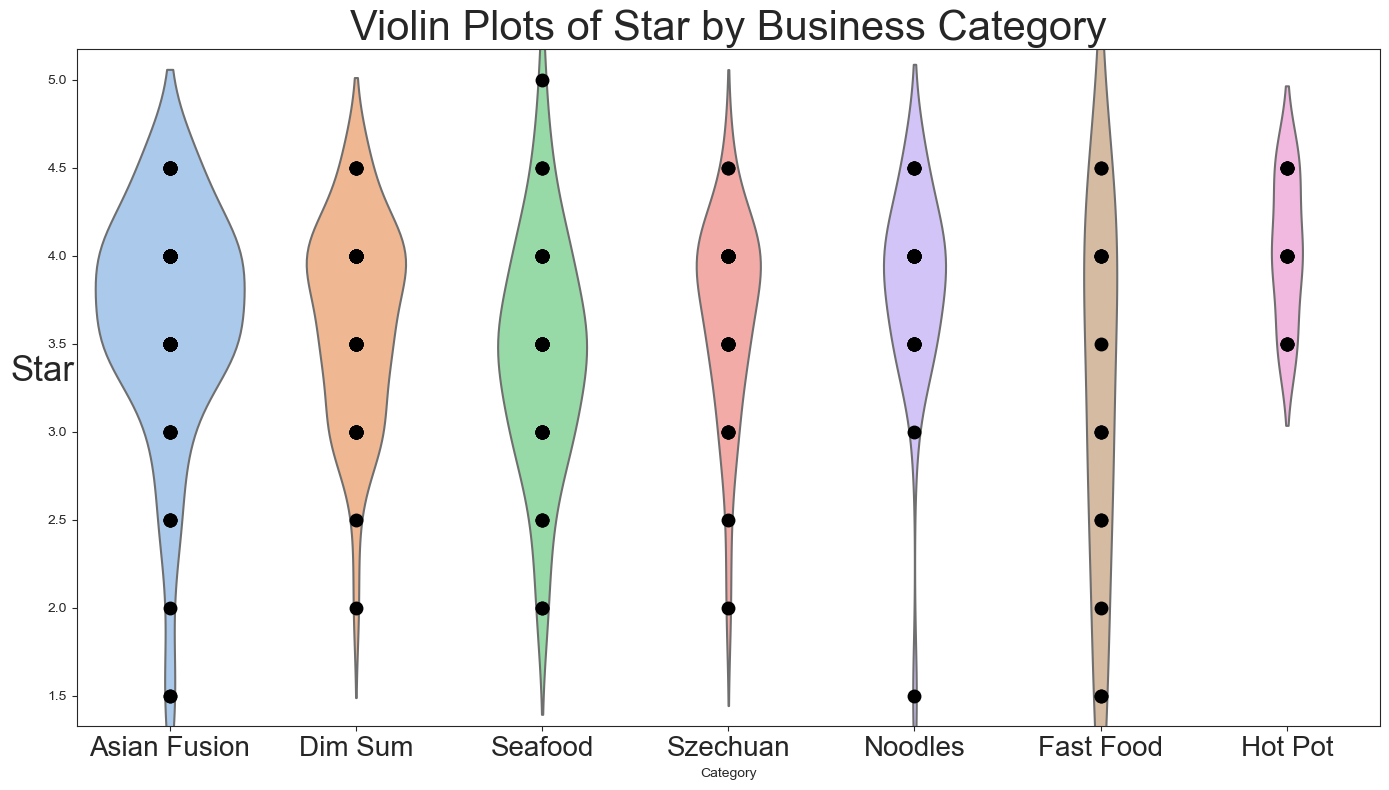

In [16]:
def filter_by_category(df, category):
    filtered_df = df[df['categories'].str.contains(category, na=False)].copy()
    filtered_df['Category'] = category
    return filtered_df[['business_id', 'avg_star', 'Category']]

all_categories_df = pd.concat([filter_by_category(business_df, 'Asian Fusion'),
                               filter_by_category(business_df, 'Dim Sum'),
                               filter_by_category(business_df, 'Seafood'),
                               filter_by_category(business_df, 'Szechuan'),
                               filter_by_category(business_df, 'Noodles'),
                               filter_by_category(business_df, 'Fast Food'),
                               filter_by_category(business_df, 'Hot Pot')])

plt.figure(figsize=(14, 8))
sns.violinplot(x='Category', y='avg_star', data=all_categories_df, scale='count', inner=None, palette=sns.color_palette("pastel"))
sns.stripplot(x='Category', y='avg_star', data=all_categories_df, color='black', jitter=False, size=10)
plt.title('Violin Plots of Star by Business Category', fontsize=30)
plt.ylabel('Star', rotation=0, fontsize=25)
plt.xticks(rotation=0, fontsize=20)
plt.tight_layout()
plt.show()

In [17]:
yelp = pd.merge(reviews_df, business_df, on='business_id', how='inner')
yelp = yelp[['business_id', 'name', 'postal_code', 'avg_star', 'review_count',
                    'user_id', 'review_id', 'date', 'stars', 'text', 'categories']]
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12414 entries, 0 to 12413
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   12414 non-null  object 
 1   name          12414 non-null  object 
 2   postal_code   12414 non-null  object 
 3   avg_star      12414 non-null  float64
 4   review_count  12414 non-null  int64  
 5   user_id       12414 non-null  object 
 6   review_id     12414 non-null  object 
 7   date          12414 non-null  object 
 8   stars         12414 non-null  float64
 9   text          12414 non-null  object 
 10  categories    12414 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.0+ MB


In [18]:
df = pd.read_csv('Trips_by_Distance.csv')
pa_trip = df[(df['State Postal Code'] == 'PA') & (df['County Name'] == 'Philadelphia County')].copy()
pa_trip['Date'] = pd.to_datetime(pa_trip['Date']).dt.strftime('%Y-%m-%d')
pa_trip.rename(columns={'Date': 'date'}, inplace=True)
# pa_trip.to_csv('pa_trip.csv', index=False)
merged_df = pd.merge(pa_trip, yelp, on='date', how='inner')
merged_df.drop(merged_df.columns[[0] + list(range(2, 6)) + list(range(8, 20))], axis=1, inplace=True)
merged_df.to_csv('merged.csv', index=False)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12414 entries, 0 to 12413
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            12414 non-null  object 
 1   Population Staying at Home      12414 non-null  float64
 2   Population Not Staying at Home  12414 non-null  float64
 3   Week                            12414 non-null  int64  
 4   Month                           12414 non-null  int64  
 5   business_id                     12414 non-null  object 
 6   name                            12414 non-null  object 
 7   postal_code                     12414 non-null  object 
 8   avg_star                        12414 non-null  float64
 9   review_count                    12414 non-null  int64  
 10  user_id                         12414 non-null  object 
 11  review_id                       12414 non-null  object 
 12  stars                           

In [19]:
trip = merged_df[['date', 'Week', 'Month', 'review_id', 'business_id', 'stars',
                  'Population Staying at Home', 'Population Not Staying at Home']].copy()
trip['At Home Percentage'] = (trip['Population Staying at Home'] 
                              / (trip['Population Staying at Home'] 
                                 + trip['Population Not Staying at Home']) * 100).round(1)
average_daily_stars = trip.groupby('date')['stars'].mean().reset_index().round(1)
perc_star = pd.merge(trip, average_daily_stars, on='date', suffixes=('', '_avg'))
perc_star['date'] = pd.to_datetime(perc_star['date'])
# perc_star

In [20]:
perc_rate = perc_star.resample('M', on='date').agg({'At Home Percentage': 'mean',
                                                       'stars_avg': 'mean'}).reset_index()
perc_rate.rename(columns={'stars_avg': 'Star Mean'}, inplace=True)
perc_rate['At Home Percentage'] = perc_rate['At Home Percentage'].round(1)
perc_rate['Star Mean'] = perc_rate['Star Mean'].round(1)
perc_rate.head()

,date,At Home Percentage,Star Mean
0,2019-01-31,26.6,4.0
1,2019-02-28,26.3,3.9
2,2019-03-31,27.1,4.0
3,2019-04-30,28.3,4.0
4,2019-05-31,27.2,3.9


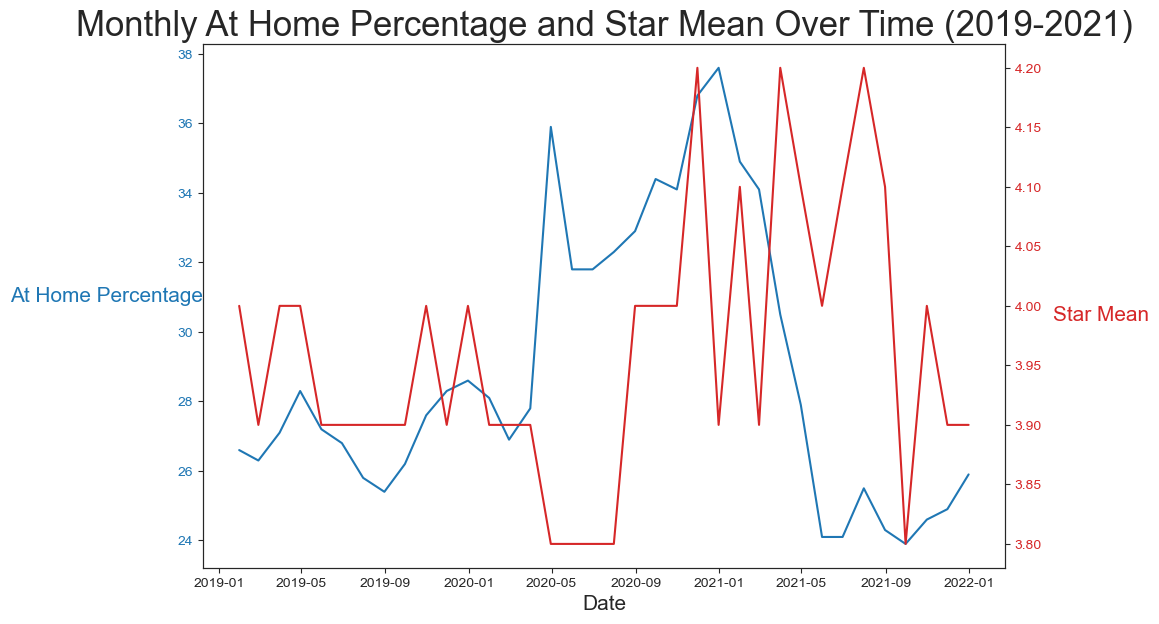

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('At Home Percentage', color=color, rotation=0, fontsize=15)
ax1.yaxis.set_label_coords(-0.12,0.5)
ax1.plot(perc_rate['date'], perc_rate['At Home Percentage'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Star Mean', color=color, rotation=0, fontsize=15)
ax2.yaxis.set_label_coords(1.12,0.5)
ax2.plot(perc_rate['date'], perc_rate['Star Mean'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Monthly At Home Percentage and Star Mean Over Time (2019-2021)', fontsize=25)
plt.show()

In [22]:
perc_num = perc_star.resample('M', on='date').agg({'At Home Percentage': 'mean',
                                                       'review_id': 'count'}).reset_index()
perc_num.rename(columns={'review_id': 'Review Count'}, inplace=True)
perc_num['At Home Percentage'] = perc_num['At Home Percentage'].round(1)
perc_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                36 non-null     datetime64[ns]
 1   At Home Percentage  36 non-null     float64       
 2   Review Count        36 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 996.0 bytes


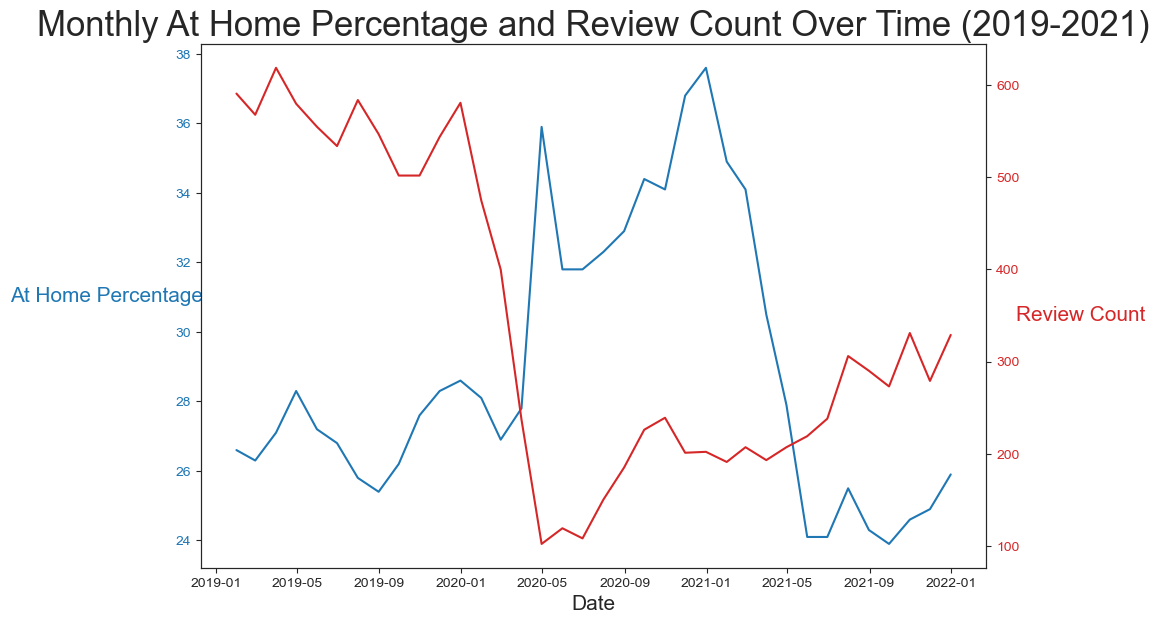

In [23]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('At Home Percentage', color=color, rotation=0, fontsize=15)
ax1.yaxis.set_label_coords(-0.12,0.5)
ax1.plot(perc_num['date'], perc_num['At Home Percentage'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Review Count', color=color, rotation=0, fontsize=15)
ax2.yaxis.set_label_coords(1.12,0.5)
ax2.plot(perc_num['date'], perc_num['Review Count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Monthly At Home Percentage and Review Count Over Time (2019-2021)', fontsize=25)
plt.show()